In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Input, InputLayer, Dropout, Dense, Flatten, Embedding, Add, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support

## Own code 
import import_ipynb
import metadata_options
import models_nn

Using TensorFlow backend.


importing Jupyter notebook from metadata_options.ipynb
importing Jupyter notebook from models_nn.ipynb


In [2]:
# Data with Throughput & WorkTime
df = pd.read_csv('./data/kokil dec 6 reprepare/conf_pc_worker_sem.csv')
df = df.dropna()

TP2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
Plot below: old throughput (x-axis) vs new throughput (y-axis)
WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
SP2: weighted by average of WT1 and WT2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)


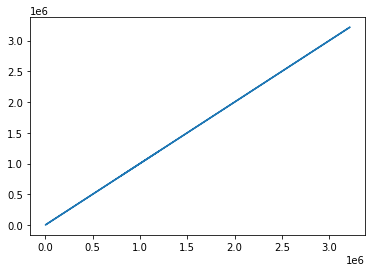

In [3]:
######################################
## Weighted Onehot Encoding options ##
######################################

##############
# Throughput #
##############
# TP1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP3 + k: weighted by 1 inverted k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP4 + k: weighted by 1 upright k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# (For TP3 & TP4, k=1 results in V-shaped variance, and as k>1 increases, sides will curve into U-shaped variance)

############
# Worktime #
############
# WT1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)

################
# PC agreement #
################
# PC1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# PC2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# PC3: weighted by 1 PC agreement weight per annotation in each OHE, i.e. (a, b, c, d) -> (w1*a, w2*b, w3*c, w4*d)

#####################
# Input text length #
#####################
# TL1: weighted by 1 normalised number of characters per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)

###################
# Special Options #
###################
# SP1: weighted by average of TP1 and TP2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# SP2: weighted by average of WT1 and WT2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# SP3: weighted by average of PC1 and PC2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# RAND_UNI: weighted by 1 uniformly distributed random number between 0 to 1 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# RAND_NORM: weighted by 1 normally distributed random number between 0 to 1 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)

# Select 1 option from each of the few variants above, e.g. TP2, WT1, PC3, TL1, SP3, and input into function
# set_OHE_pipeline_options. If not selecting TP3 or TP4, input k (option_k) will be ignored. After
# editing the options, run the entire notebook for results accordingly.

# Edit option choices here
throughput_option = 'TP2'
worktime_option = 'WT2'
pc_agreement_option = 'PC2'
textlength_option = 'TL2'
special_option = 'SP2'
k_option_for_tp = 3

df_throughput, df_worktime, df_agreement, df_textlength, df_special = metadata_options.set_OHE_pipeline_options(df, throughput_option, worktime_option, pc_agreement_option, textlength_option, special_option, k_option_for_tp)

In [4]:
######################################
## Model Options ##
######################################
# options: lstm, cnn, lstm-attn

model_name = 'lstm'
models_nn.MODEL_NAME = model_name

In [5]:
df.head()

,Input.sentence_id,HITId,Input.convo_id,Input.train_test_val,Input.msg_id,Input.timestamp,Input.full_text,Input.speaker,Input.reply_to,Input.speaker_intention,...,prt,punct,purpcl,quantmod,rcmod,rel,root,tmod,xcomp,xsubj
5,11,3MG8450X2OASXZ0WO9O5AH70GU3UPA,Game1-italy-germany,Train,Game1-italy-germany-3,87,It seems like there are a lot of ways that cou...,germany-Game1,Game1-italy-germany-2,Truth,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6,12,38G0E1M85M552JXSALX4G9WI2I6UVX,Game1-italy-germany,Train,Game1-italy-germany-7,117,"Sorry Italy I've been away doing, um, German t...",germany-Game1,Game1-italy-germany-6,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,14,3HYV4299H0WQ2B4TCS7PKDQ75WHE81,Game1-italy-germany,Train,Game1-italy-germany-8,119,"I don't think I'm ready to go for that idea, h...",germany-Game1,Game1-italy-germany-7,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
8,15,3XU9MCX6VOC4P079IHIO9TCNYLGR2P,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am pretty conflicted about whether to guess ...,italy-Game1,Game1-italy-germany-8,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,16,3FVBZG9CLJEK4WQS7P2GC1H2EEQH0Q,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am going to take it literally and say even ...,italy-Game1,Game1-italy-germany-8,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0


In [6]:
# # Old train_test_split code
# train, test, indices_train, indices_test = train_test_split(df, indices, test_size=0.2)

# New train_test_split using Stratified Shaffled Splits
y = df["Input.deception_quadrant"].copy()
X = df.drop(["Input.deception_quadrant"], axis=1)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
splits_generator = sss.split(X, y)

for train_idx, test_idx in splits_generator:
    indices_train = train_idx
    indices_test = test_idx

train = df.take(indices_train)
test = df.take(indices_test)

In [7]:
print(df.shape, train.shape, test.shape)

(11366, 862) (9092, 862) (2274, 862)


In [8]:
# check scikit-learn version
import sklearn
print('sklearn: %s' % sklearn.__version__)

sklearn: 0.23.2


In [9]:
new_deception_train = train["Input.deception_quadrant"].copy()
new_deception_train['Input.deception_quadrant'] = train["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_train_deception = new_deception_train['Input.deception_quadrant'].to_numpy()
deception_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_deception),
                                                 y_train_deception)
deception_class_weight_dict = dict(enumerate(deception_class_weights))

y_train_rapport = train['Answer.3rapport.yes_label'].tolist()
rapport_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_rapport),
                                                 y_train_rapport)
rapport_class_weight_dict = dict(enumerate(rapport_class_weights))

y_train_share_information = train['Answer.4shareinformation.yes_label'].tolist()
share_info_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_share_information),
                                                 y_train_share_information)
share_info_class_weight_dict = dict(enumerate(share_info_class_weights))

y_train_reasoning = train['Answer.2reasoning.yes_label'].tolist()
reasoning_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_reasoning),
                                                 y_train_reasoning)
reasoning_class_weight_dict = dict(enumerate(reasoning_class_weights))

y_train_gamemove = train['Answer.1gamemove.yes_label'].tolist()
gamemove_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_gamemove),
                                                 y_train_gamemove)
gamemove_class_weight_dict = dict(enumerate(gamemove_class_weights))

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[1 1 1 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0. 1.], y=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

In [10]:
print("Class weights")
print("Deception: {} \nRapport: {} \nShare Information: {} \nReasoning: {} \nGamemove: {}".format(deception_class_weight_dict,
                                                                                                  rapport_class_weight_dict,
                                                                                                  share_info_class_weight_dict,
                                                                                                  reasoning_class_weight_dict,
                                                                                                  gamemove_class_weight_dict))

Class weights
Deception: {0: 10.192825112107624, 1: 0.525792273883877} 
Rapport: {0: 3.582348305752561, 1: 0.5811069922024799} 
Share Information: {0: 3.117969821673525, 1: 0.59549384333246} 
Reasoning: {0: 2.9596354166666665, 1: 0.6016410799364743} 
Gamemove: {0: 7.048062015503876, 1: 0.5381792352314431}


In [11]:
X_train_col = train['Input.full_text']

new_deception_test = test["Input.deception_quadrant"].copy()
new_deception_test['Input.deception_quadrant'] = test["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_test_deception = new_deception_test['Input.deception_quadrant'].tolist()
y_test_rapport = test['Answer.3rapport.yes_label'].tolist()
y_test_share_information = test['Answer.4shareinformation.yes_label'].tolist()
y_test_reasoning = test['Answer.2reasoning.yes_label'].tolist()
y_test_gamemove = test['Answer.1gamemove.yes_label'].tolist()

X_test_col = test['Input.full_text']

In [12]:
le = LabelEncoder()

# def label_preprocessing(y_data, label_encoder):
#     out = label_encoder.fit_transform(y_data).reshape(-1,1)
#     return out

y_train_deception = le.fit_transform(y_train_deception)
y_train_deception = y_train_deception.reshape(-1,1)

y_train_rapport = le.fit_transform(y_train_rapport)
y_train_rapport = y_train_rapport.reshape(-1,1)

y_train_share_information = le.fit_transform(y_train_share_information)
y_train_share_information = y_train_share_information.reshape(-1,1)

y_train_reasoning = le.fit_transform(y_train_reasoning)
y_train_reasoning = y_train_reasoning.reshape(-1,1)

y_train_gamemove = le.fit_transform(y_train_gamemove)
y_train_gamemove = y_train_gamemove.reshape(-1,1)

y_train_deception = le.fit_transform(y_train_deception)
y_train_deception = y_train_deception.reshape(-1,1)

y_test_rapport = le.fit_transform(y_test_rapport)
y_test_rapport = y_test_rapport.reshape(-1,1)

y_test_share_information = le.fit_transform(y_test_share_information)
y_test_share_information = y_test_share_information.reshape(-1,1)

y_test_reasoning = le.fit_transform(y_test_reasoning)
y_test_reasoning = y_test_reasoning.reshape(-1,1)

y_test_gamemove = le.fit_transform(y_test_gamemove)
y_test_gamemove = y_test_gamemove.reshape(-1,1)

y_test_deception = le.fit_transform(y_test_deception)
y_test_deception = y_test_deception.reshape(-1,1)

y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [13]:
max_words = 1000
max_len = 220

tok = Tokenizer(num_words=max_words)

tok.fit_on_texts(X_train_col)
X_train_sequences = tok.texts_to_sequences(X_train_col)
X_train = pad_sequences(X_train_sequences, maxlen=max_len)

X_test_sequences = tok.texts_to_sequences(X_test_col)
X_test = pad_sequences(X_test_sequences, maxlen=max_len)

### Construct individual  models

In [14]:
# Rapport model
rapport_model = models_nn.create_nn_model()
rapport_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, 
                                                                              models_nn.recall_m, models_nn.precision_m])
rapport_model.fit(X_train,y_train_rapport,
                  batch_size=128,
                  epochs=50,
                  validation_data=(X_test, y_test_rapport), 
#                   callbacks=[models_nn.early_stop],
                  class_weight=rapport_class_weight_dict)

Epoch 1/50
72/72 [==============================] - 3s 43ms/step - loss: 0.6930 - accuracy: 0.3623 - f1_m: 0.3419 - recall_m: 0.3136 - precision_m: 0.6262 - val_loss: 0.6272 - val_accuracy: 0.8712 - val_f1_m: 0.9305 - val_recall_m: 1.0000 - val_precision_m: 0.8704
Epoch 2/50
72/72 [==============================] - 3s 35ms/step - loss: 0.6883 - accuracy: 0.6583 - f1_m: 0.7451 - recall_m: 0.6945 - precision_m: 0.8849 - val_loss: 0.7285 - val_accuracy: 0.4125 - val_f1_m: 0.5268 - val_recall_m: 0.3787 - val_precision_m: 0.8782
Epoch 3/50
72/72 [==============================] - 2s 35ms/step - loss: 0.6698 - accuracy: 0.6003 - f1_m: 0.7173 - recall_m: 0.6035 - precision_m: 0.9059 - val_loss: 0.5787 - val_accuracy: 0.7696 - val_f1_m: 0.8660 - val_recall_m: 0.8635 - val_precision_m: 0.8691
Epoch 4/50
72/72 [==============================] - 2s 34ms/step - loss: 0.6435 - accuracy: 0.6467 - f1_m: 0.7510 - recall_m: 0.6475 - precision_m: 0.9167 - val_loss: 0.7078 - val_accuracy: 0.5281 - val_f1

Epoch 32/50
72/72 [==============================] - 2s 34ms/step - loss: 0.3486 - accuracy: 0.7850 - f1_m: 0.8579 - recall_m: 0.7635 - precision_m: 0.9836 - val_loss: 1.0847 - val_accuracy: 0.6297 - val_f1_m: 0.7578 - val_recall_m: 0.6722 - val_precision_m: 0.8704
Epoch 33/50
72/72 [==============================] - 2s 34ms/step - loss: 0.3343 - accuracy: 0.7866 - f1_m: 0.8526 - recall_m: 0.7574 - precision_m: 0.9858 - val_loss: 1.0513 - val_accuracy: 0.6574 - val_f1_m: 0.7817 - val_recall_m: 0.7088 - val_precision_m: 0.8722
Epoch 34/50
72/72 [==============================] - 2s 34ms/step - loss: 0.3171 - accuracy: 0.7934 - f1_m: 0.8632 - recall_m: 0.7695 - precision_m: 0.9878 - val_loss: 1.1801 - val_accuracy: 0.5941 - val_f1_m: 0.7261 - val_recall_m: 0.6234 - val_precision_m: 0.8713
Epoch 35/50
72/72 [==============================] - 2s 35ms/step - loss: 0.3215 - accuracy: 0.7982 - f1_m: 0.8682 - recall_m: 0.7778 - precision_m: 0.9880 - val_loss: 1.1668 - val_accuracy: 0.6394 - va

In [15]:
rapport_pred = rapport_model.predict(X_train)
rapport_pred_test = rapport_model.predict(X_test)

rapport_pred_test_round = rapport_pred_test.round()
precision_recall_fscore_support(y_test_rapport, rapport_pred_test_round, average='macro')

(0.503282522496854, 0.5057164220504348, 0.4891135395712358, None)

In [16]:
# Game move model
gamemove_model = models_nn.create_nn_model()
gamemove_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, 
                                                                               models_nn.recall_m, models_nn.precision_m])
gamemove_model.fit(X_train,
                   y_train_gamemove,
                   batch_size=128,
                   epochs=50,
                   validation_data=(X_test, y_test_gamemove), 
#                    callbacks=[models_nn.early_stop],
                   class_weight=gamemove_class_weight_dict)

Epoch 1/50
72/72 [==============================] - 3s 42ms/step - loss: 0.6932 - accuracy: 0.6771 - f1_m: 0.7438 - recall_m: 0.7031 - precision_m: 0.9297 - val_loss: 0.6595 - val_accuracy: 0.8615 - val_f1_m: 0.9248 - val_recall_m: 0.9110 - val_precision_m: 0.9396
Epoch 2/50
72/72 [==============================] - 3s 35ms/step - loss: 0.6764 - accuracy: 0.6747 - f1_m: 0.7768 - recall_m: 0.6815 - precision_m: 0.9323 - val_loss: 1.4055 - val_accuracy: 0.0629 - val_f1_m: 8.9606e-04 - val_recall_m: 4.5167e-04 - val_precision_m: 0.0556
Epoch 3/50
72/72 [==============================] - 3s 35ms/step - loss: 0.6427 - accuracy: 0.5870 - f1_m: 0.7014 - recall_m: 0.5758 - precision_m: 0.9506 - val_loss: 0.4839 - val_accuracy: 0.7726 - val_f1_m: 0.8691 - val_recall_m: 0.8090 - val_precision_m: 0.9408
Epoch 4/50
72/72 [==============================] - 3s 35ms/step - loss: 0.5967 - accuracy: 0.6440 - f1_m: 0.7643 - recall_m: 0.6404 - precision_m: 0.9695 - val_loss: 0.4624 - val_accuracy: 0.7573 

Epoch 32/50
72/72 [==============================] - 2s 34ms/step - loss: 0.3038 - accuracy: 0.8114 - f1_m: 0.8849 - recall_m: 0.8012 - precision_m: 0.9942 - val_loss: 1.0132 - val_accuracy: 0.7674 - val_f1_m: 0.8665 - val_recall_m: 0.8071 - val_precision_m: 0.9369
Epoch 33/50
72/72 [==============================] - 2s 34ms/step - loss: 0.2889 - accuracy: 0.8203 - f1_m: 0.8877 - recall_m: 0.8062 - precision_m: 0.9957 - val_loss: 0.9519 - val_accuracy: 0.7537 - val_f1_m: 0.8573 - val_recall_m: 0.7915 - val_precision_m: 0.9370
Epoch 34/50
72/72 [==============================] - 2s 35ms/step - loss: 0.2922 - accuracy: 0.8226 - f1_m: 0.8921 - recall_m: 0.8128 - precision_m: 0.9945 - val_loss: 0.9357 - val_accuracy: 0.7023 - val_f1_m: 0.8221 - val_recall_m: 0.7345 - val_precision_m: 0.9350
Epoch 35/50
72/72 [==============================] - 2s 35ms/step - loss: 0.2754 - accuracy: 0.8380 - f1_m: 0.9000 - recall_m: 0.8246 - precision_m: 0.9959 - val_loss: 1.0243 - val_accuracy: 0.7419 - va

In [17]:
gamemove_pred = gamemove_model.predict(X_train)
gamemove_pred_test = gamemove_model.predict(X_test)

gamemove_pred_test_round = gamemove_pred_test.round()
precision_recall_fscore_support(y_test_gamemove, gamemove_pred_test_round, average='macro')

(0.49882116026353296, 0.49568612425019154, 0.44751183826781565, None)

In [18]:
# Reasoning model
reasoning_model = models_nn.create_nn_model()
reasoning_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, models_nn.recall_m, models_nn.precision_m])
reasoning_model.fit(X_train,
                    y_train_reasoning,
                    batch_size=128,
                    epochs=50,
                    validation_data=(X_test, y_test_reasoning), 
#                     callbacks=[models_nn.early_stop],
                    class_weight=reasoning_class_weight_dict)

Epoch 1/50
72/72 [==============================] - 3s 41ms/step - loss: 0.6937 - accuracy: 0.6501 - f1_m: 0.7356 - recall_m: 0.7338 - precision_m: 0.8334 - val_loss: 0.6768 - val_accuracy: 0.8210 - val_f1_m: 0.9005 - val_recall_m: 0.9984 - val_precision_m: 0.8213
Epoch 2/50
72/72 [==============================] - 2s 35ms/step - loss: 0.6885 - accuracy: 0.6325 - f1_m: 0.7392 - recall_m: 0.6776 - precision_m: 0.8605 - val_loss: 0.6197 - val_accuracy: 0.7524 - val_f1_m: 0.8532 - val_recall_m: 0.8838 - val_precision_m: 0.8263
Epoch 3/50
72/72 [==============================] - 2s 34ms/step - loss: 0.6695 - accuracy: 0.6177 - f1_m: 0.7203 - recall_m: 0.6276 - precision_m: 0.8781 - val_loss: 0.6999 - val_accuracy: 0.5312 - val_f1_m: 0.6487 - val_recall_m: 0.5326 - val_precision_m: 0.8367
Epoch 4/50
72/72 [==============================] - 2s 34ms/step - loss: 0.6479 - accuracy: 0.6142 - f1_m: 0.7209 - recall_m: 0.6097 - precision_m: 0.8936 - val_loss: 0.5992 - val_accuracy: 0.6922 - val_f1

Epoch 32/50
72/72 [==============================] - 2s 34ms/step - loss: 0.3264 - accuracy: 0.7833 - f1_m: 0.8494 - recall_m: 0.7516 - precision_m: 0.9805 - val_loss: 1.3735 - val_accuracy: 0.6161 - val_f1_m: 0.7394 - val_recall_m: 0.6687 - val_precision_m: 0.8290
Epoch 33/50
72/72 [==============================] - 3s 35ms/step - loss: 0.3112 - accuracy: 0.7998 - f1_m: 0.8668 - recall_m: 0.7815 - precision_m: 0.9768 - val_loss: 1.7958 - val_accuracy: 0.6170 - val_f1_m: 0.7402 - val_recall_m: 0.6708 - val_precision_m: 0.8282
Epoch 34/50
72/72 [==============================] - 2s 35ms/step - loss: 0.3098 - accuracy: 0.7936 - f1_m: 0.8567 - recall_m: 0.7642 - precision_m: 0.9796 - val_loss: 1.1687 - val_accuracy: 0.6091 - val_f1_m: 0.7360 - val_recall_m: 0.6694 - val_precision_m: 0.8197
Epoch 35/50
72/72 [==============================] - 2s 35ms/step - loss: 0.3030 - accuracy: 0.8066 - f1_m: 0.8690 - recall_m: 0.7841 - precision_m: 0.9777 - val_loss: 1.4710 - val_accuracy: 0.5906 - va

In [19]:
reasoning_pred = reasoning_model.predict(X_train)
reasoning_pred_test = reasoning_model.predict(X_test)

reasoning_pred_test_round = reasoning_pred_test.round()
precision_recall_fscore_support(y_test_reasoning, reasoning_pred_test_round, average='macro')

(0.5049931642649803, 0.508144581178289, 0.4773028825520252, None)

In [20]:
# Share Information model
shareinfo_model = models_nn.create_nn_model()
shareinfo_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, models_nn.recall_m, models_nn.precision_m])
shareinfo_model.fit(X_train,
                    y_train_share_information,
                    batch_size=128,
                    epochs=50,
                    validation_data=(X_test, y_test_share_information), 
#                     callbacks=[models_nn.early_stop],
                    class_weight=share_info_class_weight_dict)

Epoch 1/50
72/72 [==============================] - 3s 41ms/step - loss: 0.6931 - accuracy: 0.5455 - f1_m: 0.5977 - recall_m: 0.5684 - precision_m: 0.7751 - val_loss: 0.6502 - val_accuracy: 0.8443 - val_f1_m: 0.9147 - val_recall_m: 1.0000 - val_precision_m: 0.8436
Epoch 2/50
72/72 [==============================] - 2s 34ms/step - loss: 0.6874 - accuracy: 0.6028 - f1_m: 0.7044 - recall_m: 0.6374 - precision_m: 0.8610 - val_loss: 0.6740 - val_accuracy: 0.5383 - val_f1_m: 0.6626 - val_recall_m: 0.5409 - val_precision_m: 0.8598
Epoch 3/50
72/72 [==============================] - 2s 34ms/step - loss: 0.6623 - accuracy: 0.5763 - f1_m: 0.6832 - recall_m: 0.5624 - precision_m: 0.8972 - val_loss: 0.6194 - val_accuracy: 0.6165 - val_f1_m: 0.7431 - val_recall_m: 0.6624 - val_precision_m: 0.8484
Epoch 4/50
72/72 [==============================] - 3s 35ms/step - loss: 0.6415 - accuracy: 0.5793 - f1_m: 0.6855 - recall_m: 0.5574 - precision_m: 0.9117 - val_loss: 0.5584 - val_accuracy: 0.7062 - val_f1

Epoch 32/50
72/72 [==============================] - 2s 35ms/step - loss: 0.3415 - accuracy: 0.7899 - f1_m: 0.8577 - recall_m: 0.7675 - precision_m: 0.9765 - val_loss: 1.6535 - val_accuracy: 0.6095 - val_f1_m: 0.7372 - val_recall_m: 0.6540 - val_precision_m: 0.8470
Epoch 33/50
72/72 [==============================] - 2s 34ms/step - loss: 0.4013 - accuracy: 0.8049 - f1_m: 0.8715 - recall_m: 0.7877 - precision_m: 0.9785 - val_loss: 1.8700 - val_accuracy: 0.5858 - val_f1_m: 0.7140 - val_recall_m: 0.6168 - val_precision_m: 0.8498
Epoch 34/50
72/72 [==============================] - 2s 34ms/step - loss: 0.3145 - accuracy: 0.8055 - f1_m: 0.8707 - recall_m: 0.7852 - precision_m: 0.9794 - val_loss: 1.4936 - val_accuracy: 0.6909 - val_f1_m: 0.8081 - val_recall_m: 0.7763 - val_precision_m: 0.8449
Epoch 35/50
72/72 [==============================] - 2s 35ms/step - loss: 0.3329 - accuracy: 0.8033 - f1_m: 0.8690 - recall_m: 0.7880 - precision_m: 0.9728 - val_loss: 1.6442 - val_accuracy: 0.6530 - va

In [21]:
shareinfo_pred = shareinfo_model.predict(X_train)
shareinfo_pred_test = shareinfo_model.predict(X_test)

shareinfo_pred_test_round = shareinfo_pred_test.round()
precision_recall_fscore_support(y_test_share_information, shareinfo_pred_test_round, average='macro')

(0.5061310190369541, 0.5086996822033898, 0.5004807432614918, None)

In [22]:
# Deception model
deception_model = models_nn.create_nn_model()
deception_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, models_nn.recall_m, models_nn.precision_m])
deception_model.fit(X_train,
                    y_train_deception,
                    epochs=50,
                    validation_data=(X_test, y_test_deception), 
#                     callbacks=[models_nn.early_stop],
                    class_weight=deception_class_weight_dict)

Epoch 1/50
285/285 [==============================] - 7s 26ms/step - loss: 0.6966 - accuracy: 0.7837 - f1_m: 0.8474 - recall_m: 0.8160 - precision_m: 0.9363 - val_loss: 0.6344 - val_accuracy: 0.9507 - val_f1_m: 0.9747 - val_recall_m: 1.0000 - val_precision_m: 0.9514
Epoch 2/50
285/285 [==============================] - 7s 24ms/step - loss: 0.6864 - accuracy: 0.7758 - f1_m: 0.8477 - recall_m: 0.7988 - precision_m: 0.9537 - val_loss: 0.6484 - val_accuracy: 0.6623 - val_f1_m: 0.7921 - val_recall_m: 0.6803 - val_precision_m: 0.9573
Epoch 3/50
285/285 [==============================] - 7s 24ms/step - loss: 0.6641 - accuracy: 0.6147 - f1_m: 0.7286 - recall_m: 0.6160 - precision_m: 0.9648 - val_loss: 0.5944 - val_accuracy: 0.6570 - val_f1_m: 0.7869 - val_recall_m: 0.6715 - val_precision_m: 0.9607
Epoch 4/50
285/285 [==============================] - 7s 24ms/step - loss: 0.6488 - accuracy: 0.6509 - f1_m: 0.7685 - recall_m: 0.6514 - precision_m: 0.9738 - val_loss: 0.5214 - val_accuracy: 0.7471 

Epoch 32/50
285/285 [==============================] - 7s 24ms/step - loss: 0.3174 - accuracy: 0.8400 - f1_m: 0.9065 - recall_m: 0.8371 - precision_m: 0.9934 - val_loss: 0.7462 - val_accuracy: 0.7023 - val_f1_m: 0.8173 - val_recall_m: 0.7220 - val_precision_m: 0.9517
Epoch 33/50
285/285 [==============================] - 7s 24ms/step - loss: 0.3177 - accuracy: 0.8444 - f1_m: 0.9097 - recall_m: 0.8426 - precision_m: 0.9935 - val_loss: 0.7479 - val_accuracy: 0.6966 - val_f1_m: 0.8131 - val_recall_m: 0.7152 - val_precision_m: 0.9511
Epoch 34/50
285/285 [==============================] - 7s 24ms/step - loss: 0.2931 - accuracy: 0.8613 - f1_m: 0.9204 - recall_m: 0.8592 - precision_m: 0.9947 - val_loss: 0.7738 - val_accuracy: 0.7133 - val_f1_m: 0.8253 - val_recall_m: 0.7357 - val_precision_m: 0.9487
Epoch 35/50
285/285 [==============================] - 7s 24ms/step - loss: 0.2925 - accuracy: 0.8622 - f1_m: 0.9212 - recall_m: 0.8621 - precision_m: 0.9928 - val_loss: 0.7457 - val_accuracy: 0.6

In [23]:
deception_pred = deception_model.predict(X_train)
deception_pred_test = deception_model.predict(X_test)
deception_pred_test_round = deception_pred_test.round()
precision_recall_fscore_support(y_test_deception, deception_pred_test_round, average='macro')

(0.4962712020295698, 0.48392691951896394, 0.44596945760926804, None)

In [24]:
# deception_pred_test

In [25]:
# unique, counts = np.unique(deception_pred_test_round, return_counts=True)

In [26]:
# print(unique, counts)

In [27]:
# deception_model.history.history['val_f1_m']

### One hot encodings

In [28]:
# Train encodings
pred_df_arr_full = []
pred_df_arr = []
for i in range(0, len(gamemove_pred)):
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = gamemove_pred[i][0]
    pred_obj_1['reasoning'] = reasoning_pred[i][0]
    pred_obj_1['shareinfo'] = shareinfo_pred[i][0]
    pred_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = rapport_pred[i][0]
    pred_df_arr_full.append(pred_obj_2)
    
pred_df_full = pd.DataFrame(pred_df_arr_full)
pred_df = pd.DataFrame(pred_df_arr)

In [29]:
# Test encodings
pred_test_df_arr_full = []
pred_test_df_arr = []

for i in range(0, len(gamemove_pred_test)):
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = gamemove_pred_test[i][0]
    pred_obj_1['reasoning'] = reasoning_pred_test[i][0]
    pred_obj_1['shareinfo'] = shareinfo_pred_test[i][0]
    pred_test_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = rapport_pred_test[i][0]
    pred_test_df_arr_full.append(pred_obj_2)
    
pred_test_df_full = pd.DataFrame(pred_test_df_arr_full)
pred_test_df = pd.DataFrame(pred_test_df_arr)

### Joint Model with one hot encoding 

In [30]:
print('Joint full model with one hot encoding, predicting deception')
joint_full_model = models_nn.create_joint_model(pred_df_full)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_test_df_full,y_test_deception), 
#                                callbacks=[models_nn.callback], 
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception
Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6935 - acc: 0.6189 - f1_m: 0.6562 - precision_m: 0.6809 - recall_m: 0.6345 - val_loss: 0.6965 - val_acc: 0.0493 - val_

143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.8564 - f1_m: 0.9220 - precision_m: 0.9512 - recall_m: 0.8957 - val_loss: 0.6931 - val_acc: 0.8536 - val_f1_m: 0.9198 - val_precision_m: 0.9499 - val_recall_m: 0.8927
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.8854 - f1_m: 0.9390 - precision_m: 0.9516 - recall_m: 0.9275 - val_loss: 0.6923 - val_acc: 0.8716 - val_f1_m: 0.9303 - val_precision_m: 0.9511 - val_recall_m: 0.9116
Epoch 31/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6932 - acc: 0.8784 - f1_m: 0.9347 - precision_m: 0.9513 - recall_m: 0.9198 - val_loss: 0.6907 - val_acc: 0.8764 - val_f1_m: 0.9331 - val_precision_m: 0.9514 - val_recall_m: 0.9167
Epoch 32/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6931 - acc: 0.8950 - f1_m: 0.9443 - precision_m: 0.9514 - recall_m: 0.9380 - val_loss: 0.6921 - val_acc: 0.8773 - val_f1_m: 0.9336 - val_precision_m: 0.9515 - val_r

In [31]:
joint_predict = joint_full_model.predict(pred_test_df_full)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

(0.50487990559933, 0.5079415554380865, 0.5036981351698717, None)

In [32]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [ 189 2085]


In [33]:
print('Joint full model with one hot encoding, predicting rapport')
joint_full_model = models_nn.create_joint_model(pred_df)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_test_df,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport
Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 8         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6954 - acc: 0.8047 - f1_m: 0.8868 - precision_m: 0.8733 - recall_m: 0.9081 - val_loss: 0.6825 - val_acc: 0.6693 - val_f1

143/143 [==============================] - 0s 3ms/step - loss: 0.6050 - acc: 0.6940 - f1_m: 0.7967 - precision_m: 0.9293 - recall_m: 0.7002 - val_loss: 0.7297 - val_acc: 0.5251 - val_f1_m: 0.6632 - val_precision_m: 0.8666 - val_recall_m: 0.5406
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6045 - acc: 0.6936 - f1_m: 0.7964 - precision_m: 0.9299 - recall_m: 0.6993 - val_loss: 0.7291 - val_acc: 0.5255 - val_f1_m: 0.6636 - val_precision_m: 0.8668 - val_recall_m: 0.5411
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6042 - acc: 0.6877 - f1_m: 0.7893 - precision_m: 0.9305 - recall_m: 0.6879 - val_loss: 0.7320 - val_acc: 0.5233 - val_f1_m: 0.6616 - val_precision_m: 0.8663 - val_recall_m: 0.5386
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6042 - acc: 0.6929 - f1_m: 0.7931 - precision_m: 0.9293 - recall_m: 0.6944 - val_loss: 0.7327 - val_acc: 0.5237 - val_f1_m: 0.6618 - val_precision_m: 0.8671 - val_r

In [34]:
joint_predict = joint_full_model.predict(pred_test_df)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.4953197945845005, 0.4896370468253872, 0.4278434547657409, None)

In [35]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [1050 1224]


## Weighted against Throughput, WorkTime, PC Agreement & Text Length

In [36]:
# Train weighted encodings
pred_df_full_throughput, pred_df_throughput, pred_df_full_worktime, pred_df_worktime, pred_df_full_agreement, pred_df_agreement, pred_df_full_textlength, pred_df_textlength, pred_df_full_special, pred_df_special = metadata_options.construct_weighted_dataframe(indices_train, df_throughput, df_worktime, df_agreement, df_textlength, df_special, pred_df, pred_df_full)

In [37]:
# Test weighted encodings
pred_df_full_throughput_test, pred_df_throughput_test, pred_df_full_worktime_test, pred_df_worktime_test, pred_df_full_agreement_test, pred_df_agreement_test, pred_df_full_textlength_test, pred_df_textlength_test, pred_df_full_special_test, pred_df_special_test = metadata_options.construct_weighted_dataframe(indices_test, df_throughput, df_worktime, df_agreement, df_textlength, df_special, pred_test_df, pred_test_df_full)

## Throughput only

### Joint Model with one hot encoding 

In [38]:
print('Joint full model with one hot encoding, predicting deception, weighted by throughput')
joint_full_model = models_nn.create_joint_model(pred_df_full_throughput)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_throughput, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_throughput_test,y_test_deception), 
#                                callbacks=[models_nn.callback], 
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by throughput
Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6932 - acc: 0.9412 - f1_m: 0.9690 - precision_m: 0.9513 - recall_m: 0.9896 - val_loss: 0.6858 

143/143 [==============================] - 0s 3ms/step - loss: 0.6913 - acc: 0.5785 - f1_m: 0.7212 - precision_m: 0.9545 - recall_m: 0.5848 - val_loss: 0.6856 - val_acc: 0.5018 - val_f1_m: 0.6538 - val_precision_m: 0.9497 - val_recall_m: 0.5010
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6912 - acc: 0.4423 - f1_m: 0.5896 - precision_m: 0.9576 - recall_m: 0.4333 - val_loss: 0.6808 - val_acc: 0.5550 - val_f1_m: 0.7036 - val_precision_m: 0.9488 - val_recall_m: 0.5614
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6914 - acc: 0.5972 - f1_m: 0.7304 - precision_m: 0.9556 - recall_m: 0.6041 - val_loss: 0.6871 - val_acc: 0.4872 - val_f1_m: 0.6401 - val_precision_m: 0.9482 - val_recall_m: 0.4856
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6913 - acc: 0.5015 - f1_m: 0.6520 - precision_m: 0.9564 - recall_m: 0.5006 - val_loss: 0.6898 - val_acc: 0.4560 - val_f1_m: 0.6094 - val_precision_m: 0.9482 - val_r

In [39]:
joint_predict = joint_full_model.predict(pred_df_full_throughput_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

(0.49962910010314926, 0.49803835734108626, 0.35093799948360016, None)

In [40]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [1247 1027]


In [41]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

In [42]:
print('Joint full model with one hot encoding, predicting rapport, weighted by throughput')
joint_full_model = models_nn.create_joint_model(pred_df_throughput)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_throughput, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_throughput_test,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by throughput
Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6966 - acc: 0.6605 - f1_m: 0.7734 - precision_m: 0.8634 - recall_m: 0.7191 - val_loss: 0.6951 - 

143/143 [==============================] - 1s 4ms/step - loss: 0.6881 - acc: 0.5152 - f1_m: 0.6355 - precision_m: 0.8947 - recall_m: 0.4964 - val_loss: 0.7016 - val_acc: 0.4134 - val_f1_m: 0.5449 - val_precision_m: 0.8302 - val_recall_m: 0.4098
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6880 - acc: 0.5077 - f1_m: 0.6254 - precision_m: 0.8898 - recall_m: 0.4864 - val_loss: 0.6979 - val_acc: 0.4261 - val_f1_m: 0.5600 - val_precision_m: 0.8335 - val_recall_m: 0.4264
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6876 - acc: 0.5197 - f1_m: 0.6386 - precision_m: 0.8944 - recall_m: 0.5009 - val_loss: 0.7056 - val_acc: 0.3980 - val_f1_m: 0.5273 - val_precision_m: 0.8251 - val_recall_m: 0.3921
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6875 - acc: 0.5046 - f1_m: 0.6214 - precision_m: 0.8941 - recall_m: 0.4807 - val_loss: 0.7058 - val_acc: 0.4028 - val_f1_m: 0.5321 - val_precision_m: 0.8282 - val_r

In [43]:
joint_predict = joint_full_model.predict(pred_df_throughput_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.4670821196884661, 0.42895217880444425, 0.35074195705100975, None)

In [44]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [1337  937]


## WorkTime only

### Joint Model with one hot encoding 

In [45]:
print('Joint full model with one hot encoding, predicting deception, weighted by worktime')
joint_full_model = models_nn.create_joint_model(pred_df_full_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_worktime, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_worktime_test,y_test_deception), 
#                                callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by worktime
Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6933 - acc: 0.9399 - f1_m: 0.9650 - precision_m: 0.9475 - recall_m: 0.9882 - val_loss: 0.6921 - 

143/143 [==============================] - 0s 3ms/step - loss: 0.6917 - acc: 0.4452 - f1_m: 0.4740 - precision_m: 0.9312 - recall_m: 0.4419 - val_loss: 0.6899 - val_acc: 0.1218 - val_f1_m: 0.1450 - val_precision_m: 0.9600 - val_recall_m: 0.0794
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6916 - acc: 0.5288 - f1_m: 0.5453 - precision_m: 0.9294 - recall_m: 0.5367 - val_loss: 0.6901 - val_acc: 0.1179 - val_f1_m: 0.1377 - val_precision_m: 0.9521 - val_recall_m: 0.0752
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6917 - acc: 0.0950 - f1_m: 0.0937 - precision_m: 0.8989 - recall_m: 0.0502 - val_loss: 0.6945 - val_acc: 0.0792 - val_f1_m: 0.0622 - val_precision_m: 0.7722 - val_recall_m: 0.0329
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6915 - acc: 0.0970 - f1_m: 0.0976 - precision_m: 0.9224 - recall_m: 0.0523 - val_loss: 0.6943 - val_acc: 0.0906 - val_f1_m: 0.0851 - val_precision_m: 0.9250 - val_r

In [46]:
joint_predict = joint_full_model.predict(pred_df_full_worktime_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

(0.5052540353157838, 0.5048070569578432, 0.09057168317934564, None)

In [47]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [2172  102]


In [48]:
print('Joint full model with one hot encoding, predicting rapport, weighted by worktime')
joint_full_model = models_nn.create_joint_model(pred_df_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_worktime, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_worktime_test,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by worktime
Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_18 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6933 - acc: 0.5630 - f1_m: 0.5805 - precision_m: 0.5612 - recall_m: 0.6036 - val_loss: 0.6935 - va

Epoch 29/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6927 - acc: 0.6723 - f1_m: 0.7405 - precision_m: 0.8715 - recall_m: 0.7251 - val_loss: 0.6982 - val_acc: 0.2089 - val_f1_m: 0.1820 - val_precision_m: 0.8886 - val_recall_m: 0.1027
Epoch 30/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6926 - acc: 0.3132 - f1_m: 0.3552 - precision_m: 0.8952 - recall_m: 0.2290 - val_loss: 0.6942 - val_acc: 0.2916 - val_f1_m: 0.3386 - val_precision_m: 0.8905 - val_recall_m: 0.2115
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6925 - acc: 0.6194 - f1_m: 0.6562 - precision_m: 0.8616 - recall_m: 0.6575 - val_loss: 0.6982 - val_acc: 0.2208 - val_f1_m: 0.2089 - val_precision_m: 0.8783 - val_recall_m: 0.1199
Epoch 32/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6925 - acc: 0.5339 - f1_m: 0.5631 - precision_m: 0.8627 - recall_m: 0.5396 - val_loss: 0.7026 - val_acc: 0.1979 - val_f1_m: 0.1605 - val_precision_m: 0.

In [49]:
joint_predict = joint_full_model.predict(pred_df_worktime_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.5127783495792214, 0.5090906271697164, 0.19651624101165385, None)

In [50]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [2075  199]


## PC Agreement only

### Joint Model with one hot encoding 

In [51]:
print('Joint full model with one hot encoding, predicting deception, weighted by PC Agreement')
joint_full_model = models_nn.create_joint_model(pred_df_full_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_agreement, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_agreement_test,y_test_deception), 
#                                callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by PC Agreement
Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_21 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6932 - acc: 0.2498 - f1_m: 0.3079 - precision_m: 0.9460 - recall_m: 0.2302 - val_loss: 0.691

143/143 [==============================] - 1s 4ms/step - loss: 0.6931 - acc: 0.5976 - f1_m: 0.6635 - precision_m: 0.9530 - recall_m: 0.6062 - val_loss: 0.6910 - val_acc: 0.2463 - val_f1_m: 0.3506 - val_precision_m: 0.9533 - val_recall_m: 0.2174
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.9321 - f1_m: 0.9597 - precision_m: 0.9513 - recall_m: 0.9802 - val_loss: 0.6887 - val_acc: 0.9507 - val_f1_m: 0.9745 - val_precision_m: 0.9506 - val_recall_m: 1.0000
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.8700 - f1_m: 0.9063 - precision_m: 0.9502 - recall_m: 0.9108 - val_loss: 0.6904 - val_acc: 0.2524 - val_f1_m: 0.3596 - val_precision_m: 0.9527 - val_recall_m: 0.2242
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6931 - acc: 0.3288 - f1_m: 0.4280 - precision_m: 0.9473 - recall_m: 0.3091 - val_loss: 0.6909 - val_acc: 0.2507 - val_f1_m: 0.3570 - val_precision_m: 0.9523 - val_r

In [52]:
joint_predict = joint_full_model.predict(pred_df_full_throughput_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.4470111172558746, 0.4404074199778441, 0.44355477770485424, None)

In [53]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [ 337 1937]


In [54]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

In [55]:
print('Joint full model with one hot encoding, predicting rapport, weighted by PC Agreement')
joint_full_model = models_nn.create_joint_model(pred_df_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_agreement, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_agreement_test,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by PC Agreement
Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_24 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6932 - acc: 0.8557 - f1_m: 0.9191 - precision_m: 0.8590 - recall_m: 0.9939 - val_loss: 0.6926 

Epoch 29/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.4713 - f1_m: 0.4262 - precision_m: 0.4094 - recall_m: 0.4618 - val_loss: 0.6955 - val_acc: 0.1288 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.1401 - f1_m: 0.0015 - precision_m: 0.0420 - recall_m: 7.7544e-04 - val_loss: 0.6943 - val_acc: 0.1288 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 31/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6932 - acc: 0.7253 - f1_m: 0.7552 - precision_m: 0.7086 - recall_m: 0.8183 - val_loss: 0.6925 - val_acc: 0.8712 - val_f1_m: 0.9299 - val_precision_m: 0.8698 - val_recall_m: 1.0000
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.6298 - f1_m: 0.6320 - precision_m: 0.6001 - recall_m: 0.6856 - val_loss: 0.6935 - val_acc: 0.1288 - val_f1_m: 

In [56]:
joint_predict = joint_full_model.predict(pred_df_throughput_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.4983476761275305, 0.4996649053379115, 0.13637846349528185, None)

In [57]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [2221   53]


## Text Length only

### Joint Model with one hot encoding 

In [58]:
print('Joint full model with one hot encoding, predicting deception, weighted by text length')
joint_full_model = models_nn.create_joint_model(pred_df_full_textlength)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_textlength, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_textlength_test,y_test_deception), 
#                                callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by text length
Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_27 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6931 - acc: 0.9415 - f1_m: 0.9677 - precision_m: 0.9519 - recall_m: 0.9892 - val_loss: 0.6889

143/143 [==============================] - 0s 3ms/step - loss: 0.6919 - acc: 0.7084 - f1_m: 0.8241 - precision_m: 0.9548 - recall_m: 0.7285 - val_loss: 0.6892 - val_acc: 0.6372 - val_f1_m: 0.7719 - val_precision_m: 0.9517 - val_recall_m: 0.6513
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6919 - acc: 0.6524 - f1_m: 0.7807 - precision_m: 0.9549 - recall_m: 0.6662 - val_loss: 0.6896 - val_acc: 0.6310 - val_f1_m: 0.7666 - val_precision_m: 0.9518 - val_recall_m: 0.6437
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6920 - acc: 0.6676 - f1_m: 0.7919 - precision_m: 0.9548 - recall_m: 0.6860 - val_loss: 0.6833 - val_acc: 0.6909 - val_f1_m: 0.8128 - val_precision_m: 0.9518 - val_recall_m: 0.7112
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6918 - acc: 0.5635 - f1_m: 0.7064 - precision_m: 0.9563 - recall_m: 0.5703 - val_loss: 0.6781 - val_acc: 0.7313 - val_f1_m: 0.8412 - val_precision_m: 0.9509 - val_r

In [59]:
joint_predict = joint_full_model.predict(pred_df_full_textlength_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

(0.5007924154521013, 0.5031221091581868, 0.4632621849343301, None)

In [60]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [ 555 1719]


In [61]:
print('Joint full model with one hot encoding, predicting rapport, weighted by text length')
joint_full_model = models_nn.create_joint_model(pred_df_textlength)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_textlength, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_textlength_test,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by text length
Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_30 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6938 - acc: 0.2958 - f1_m: 0.3063 - precision_m: 0.5434 - recall_m: 0.2219 - val_loss: 0.6964 -

143/143 [==============================] - 0s 3ms/step - loss: 0.6924 - acc: 0.4128 - f1_m: 0.5115 - precision_m: 0.8815 - recall_m: 0.3693 - val_loss: 0.6966 - val_acc: 0.3039 - val_f1_m: 0.3911 - val_precision_m: 0.8161 - val_recall_m: 0.2592
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6922 - acc: 0.4608 - f1_m: 0.5733 - precision_m: 0.8762 - recall_m: 0.4344 - val_loss: 0.6948 - val_acc: 0.3465 - val_f1_m: 0.4572 - val_precision_m: 0.8259 - val_recall_m: 0.3189
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6920 - acc: 0.4825 - f1_m: 0.6022 - precision_m: 0.8798 - recall_m: 0.4629 - val_loss: 0.6932 - val_acc: 0.3799 - val_f1_m: 0.5030 - val_precision_m: 0.8320 - val_recall_m: 0.3641
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6918 - acc: 0.4143 - f1_m: 0.5187 - precision_m: 0.8851 - recall_m: 0.3707 - val_loss: 0.6922 - val_acc: 0.4059 - val_f1_m: 0.5384 - val_precision_m: 0.8305 - val_r

In [62]:
joint_predict = joint_full_model.predict(pred_df_textlength_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.465365533505384, 0.42490261580578637, 0.35142348360019804, None)

In [63]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [1322  952]


## Other special options (either SP1, SP2, SP3, RAND_UNI, or RAND_NORM)

### Joint Model with one hot encoding 

In [64]:
print('Joint full model with one hot encoding, predicting deception, weighted by special option')
joint_full_model = models_nn.create_joint_model(pred_df_full_special)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_special, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_special_test,y_test_deception), 
#                                callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by special option
Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_33 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6938 - acc: 0.8394 - f1_m: 0.8698 - precision_m: 0.9423 - recall_m: 0.8724 - val_loss: 0.6

143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.6588 - f1_m: 0.7111 - precision_m: 0.8632 - recall_m: 0.6801 - val_loss: 0.6905 - val_acc: 0.9085 - val_f1_m: 0.9519 - val_precision_m: 0.9506 - val_recall_m: 0.9539
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.8534 - f1_m: 0.9189 - precision_m: 0.9511 - recall_m: 0.8931 - val_loss: 0.6899 - val_acc: 0.9464 - val_f1_m: 0.9722 - val_precision_m: 0.9508 - val_recall_m: 0.9950
Epoch 31/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.9485 - f1_m: 0.9726 - precision_m: 0.9495 - recall_m: 0.9975 - val_loss: 0.6900 - val_acc: 0.9081 - val_f1_m: 0.9517 - val_precision_m: 0.9505 - val_recall_m: 0.9535
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6932 - acc: 0.8559 - f1_m: 0.9135 - precision_m: 0.9452 - recall_m: 0.8885 - val_loss: 0.6932 - val_acc: 0.0704 - val_f1_m: 0.0451 - val_precision_m: 0.6171 - val_r

In [65]:
joint_predict = joint_full_model.predict(pred_df_full_special_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

(0.4967717717717718, 0.4984017774547377, 0.0697554352874154, None)

In [66]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [2220   54]


In [67]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

In [68]:
print('Joint full model with one hot encoding, predicting rapport, weighted by special option')
joint_full_model = models_nn.create_joint_model(pred_df_special)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_special, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_special_test,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by special option
Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_36 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6934 - acc: 0.5258 - f1_m: 0.5416 - precision_m: 0.8522 - recall_m: 0.5419 - val_loss: 0.689

143/143 [==============================] - 0s 3ms/step - loss: 0.6925 - acc: 0.4017 - f1_m: 0.4864 - precision_m: 0.8764 - recall_m: 0.3563 - val_loss: 0.6904 - val_acc: 0.4288 - val_f1_m: 0.5552 - val_precision_m: 0.8522 - val_recall_m: 0.4147
Epoch 30/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6925 - acc: 0.4357 - f1_m: 0.5373 - precision_m: 0.8722 - recall_m: 0.3984 - val_loss: 0.6955 - val_acc: 0.3122 - val_f1_m: 0.3924 - val_precision_m: 0.8405 - val_recall_m: 0.2577
Epoch 31/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6924 - acc: 0.3435 - f1_m: 0.4107 - precision_m: 0.8840 - recall_m: 0.2757 - val_loss: 0.6875 - val_acc: 0.5356 - val_f1_m: 0.6750 - val_precision_m: 0.8584 - val_recall_m: 0.5594
Epoch 32/32
143/143 [==============================] - 0s 3ms/step - loss: 0.6924 - acc: 0.6368 - f1_m: 0.7270 - precision_m: 0.8687 - recall_m: 0.6755 - val_loss: 0.6948 - val_acc: 0.3303 - val_f1_m: 0.4190 - val_precision_m: 0.8484 - val_r

In [69]:
joint_predict = joint_full_model.predict(pred_df_special_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.48526163778457354, 0.47309767018760135, 0.312939827466322, None)

In [70]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [1620  654]
